# Introduction and Background

## Research Question
Are there specific months for movie release dates that generate more revenue in the box office? Is there a correlation between movie budgets and their success in the box office?

## Background
This is a question of interest because the film industry may be able to find some different strategies to maximize their revenue, such as the best time to release their new movies or determine how much their budget will correlate to potential revenue. With so many movies always coming out, we wondered if there was a correlation between box office success and release dates in conjunction with how big a movie’s budgets is. In some of our background research we found that the number of user votes on IMDB for a movie corresponds with how well-known the film is, and that critics’ reviews don’t have that much of an influence on the success of a movie. 

We always hear about big budget movies because they’re the ones that usually have the ability to advertise the film to the point where everyone sees it. But sometimes movies with relatively small budgets rise to the top of the the box offices. Content has something to do with it, but we want to see how much of an impact the time at which you release a movie has on the success of the film. There have been some blog posts about which genre generally gets released for each month, and there was some indication that the winter months would be when the best movies (Oscar nominated ones) come out. 

Our question is important because it presents a visualization for the correlation between box office success and release dates in conjuction with movie budgets. We want to know if there is a strong correlation and if there is a pattern to movie release dates. It is unclear if there are popular months for movie releases or box office success. 

References (include links):
- Movie Budget and Financial Performance Records (https://www.the-numbers.com/movie/budgets/) 
-- Tables that show top 20 movies that compare the movie's budget and revenue (greatest lost and earnings).
- Analysis of factor affecting the success of the movie (http://rstudio-pubs-static.s3.amazonaws.com/233939_bbeb292c0c20440f97d31b616662c06f.html)
-- Analysis between different website user voting data and the success of the movie in the box office in conjuction with the movie's budget. 
- Movie Release Calendar Strategy (https://riotstudios.com/blog/movie-release-calendar-strategy/) 
-- Months associated with genre/movie style released.

## Hypothesis
We predict that if a movie is released during July or August, then it will generate more revenue in the box office. We also predict that if a movie has a big budget, then it will generate more revenue in the box office. 

# Data Description

This is a list of ~5000 movies from The Movie Database website. This dataset contains rows of movies with columns that dictate details of the movie. For example, the list contains keyword, revenue, budget, production company, imdb id, language, runtime, release date, and ratings concerning each movie.

- Dataset Name: TMDb 5000 Movie Dataset
- Link to the dataset: https://www.kaggle.com/tmdb/tmdb-movie-metadata/data
- Number of observations: 4803

This is a list of ~45000 movies from The Movie Database. This list contains budget, genre, original language, popularity, revenue, imdb id, adulterated, production company, homepage, collection, poster, overview, video, tagline, title, vote count, id, runtime, release date, and vote average (0-10) for each movie. 

- Dataset Name: Movies Metadata
- Link to the dataset: https://www.kaggle.com/rounakbanik/the-movies-dataset/data
- Number of observations: 45466

We may be merging the datasets and compare if there are any duplicates, if so, we will compare the ‘revenue’, ‘budget’, and ‘release date’ and remove the duplicates. If there are any conflicting comparisons, we will manually change the data to the correct values. 

## Data Cleaning/Pre-processing


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

!pip install easymoney
from easymoney.money import EasyPeasy

C:\Users\amilkcarton\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


You are using pip version 9.0.1, however version 9.0.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
# Import datafile tmdb_5000_movies.csv to df1

df1 = pd.read_csv('tmdb_5000_movies.csv')

In [3]:
# Import datafile movies_metadata.csv to df2
df2 = pd.read_csv('movies_metadata.csv', low_memory=False)

In [4]:
# Drop unrelated columns
df1.drop(['homepage', 'keywords', 'overview', 'runtime', 'tagline'], axis=1, inplace=True)
df2.drop(['adult', 'belongs_to_collection', 'homepage', 'imdb_id', 'overview', 'poster_path', 'runtime', 'video', 'tagline'], axis=1, inplace=True)

In [5]:
# Change str to int and drop all unnemerical elements
pd.to_numeric(df1['revenue'], errors='coerce')
pd.to_numeric(df1['budget'], errors='coerce')
pd.to_numeric(df2['revenue'], errors='coerce')
pd.to_numeric(df2['budget'], errors='coerce') 

df1.dropna(subset = ["revenue","budget"],inplace=True)
df2.dropna(subset = ["revenue","budget"],inplace=True)
df2.budget = df2.budget.astype(np.int64)

In [6]:
# Drop unrepresentable/abnormal value for revenue and budget 
df1 = df1[df1.revenue >= 1000]
df2 = df2[df2.revenue >= 1000]
df1 = df1[df1.budget >= 1000]
df2 = df2[df2.budget >= 1000]

In [7]:
# Concat two dataset into one called df
df = pd.concat([df1, df2], ignore_index=True)

In [8]:
# Drop repeated infomation.
df.drop_duplicates('id', inplace=True)

In [9]:
# Split the release date to year month and date 
df['year'] = pd.DatetimeIndex(df['release_date']).year
df['month'] = pd.DatetimeIndex(df['release_date']).month
df['date'] = pd.DatetimeIndex(df['release_date']).day

In [10]:
# Remove the movies that may be too old
df = df[df.year >= 1990]

In [11]:
# Adjust inflation rate 
ep = EasyPeasy()

In [12]:
# Adjust the inflation of budget, make a new column called adjusted_budget
adjusted_budget = []
for index, row in df.iterrows():
    adjusted_budget.append(ep.normalize(amount=row['budget'], region="US", from_year=row['year'], to_year='latest',base_currency="USD", pretty_print=False))
df['adjusted_budget'] = adjusted_budget

C:\Users\amilkcarton\Anaconda3\lib\site-packages\easymoney\money.py:213: UserWarning: 
Inflation (CPI) data for 2017 in 'United States' could not be obtained from the
International Monetary Fund database currently cached.
Falling back to 2016.
  warn(warn_msg % (year, natural_region_name, str(fall_back_year)))


In [13]:
# Adjust the inflation of revenue, make a new column called adjusted_revenue
adjusted_revenue = []
for index, row in df.iterrows():
    adjusted_revenue.append(ep.normalize(amount=row['revenue'], region="US", from_year=row['year'], to_year='latest',base_currency="USD", pretty_print=False))
df['adjusted_revenue'] = adjusted_revenue

C:\Users\amilkcarton\Anaconda3\lib\site-packages\easymoney\money.py:213: UserWarning: 
Inflation (CPI) data for 2017 in 'United States' could not be obtained from the
International Monetary Fund database currently cached.
Falling back to 2016.
  warn(warn_msg % (year, natural_region_name, str(fall_back_year)))


In [14]:
# Add column return_rate and profit
df['return_rate'] = df['adjusted_revenue']/df['adjusted_budget']
df['profit'] = df['adjusted_revenue']- df['adjusted_budget']

In [15]:
# In this step, we are going to deal with outlier values by removing all rows in which the data for the return rate column exceeds +/- 3 standard deviations above or below the mean.
std3 = 3 * df['return_rate'].std()
std_max = df['return_rate'].mean() + std3
std_min = df['return_rate'].mean() - std3

In [16]:
# Now use these values to remove any rows with return_rate data above or below these thresholds
df = df[df['return_rate'] > std_min]
df = df[df['return_rate'] < std_max]

In [17]:
# Use the method below to extract the main genres. 
def extract_main_genre(genres):
    s = genres
    # Find the first : after id
    start = s.find(':') + 1
    s = s[start:]
    start = s.find(':') + 3
    end = s.find('}') - 1
    return s[start:end]
df['main_genre'] = df["genres"].apply(extract_main_genre)

In [18]:
# Use the method below to extract the main production company
def extract_main_production(companies):
    return companies[companies.find(':') + 3: companies.find(",") - 1]
df['main_production_company'] = df['production_companies'].apply(extract_main_production)

In [19]:
# Check if any rows have empty genre
empty_genre = sum(df.main_genre == '')
empty_production = sum(df.main_production_company == '')

print ("There are ", empty_genre, " rows that do not contain a genre.")
print ("There are ", empty_production, " rows that do not contain a production company.")

There are  9  rows that do not contain a genre.
There are  184  rows that do not contain a production company.


In [20]:
# Function to check empty column values
def empty_string(string):
    output = None
    if (string == ''):
        output = np.nan
    else:
        output = string
    return output

In [21]:
# Applying the transformation and dropping invalid rows
df["main_production_company"] = df["main_production_company"].apply(empty_string)
df.dropna(subset=['main_production_company'], inplace=True)

In [22]:
# Applying the transformation and dropping invalid rows
df["main_genre"] = df["main_genre"].apply(empty_string)
df.dropna(subset=['main_genre'], inplace=True)

In [23]:
# Drop used, cleaned columns
df.drop(['original_title', 'production_countries', 'spoken_languages', 'status', 'budget', 'genres', 'popularity', 'original_language', 'id', 'production_companies', 'release_date', 'year', 'date', 'revenue', 'budget', 'vote_count'], axis=1, inplace=True)

In [24]:
# Check what the df looks like as of now
df.head()
df

,title,vote_average,month,adjusted_budget,adjusted_revenue,return_rate,profit,main_genre,main_production_company
0,Avatar,7.2,12,2.651370e+08,3.118957e+09,11.763566,2.853820e+09,Action,Ingenious Film Partners
1,Pirates of the Caribbean: At World's End,6.9,5,3.472620e+08,1.112396e+09,3.203333,7.651340e+08,Adventure,Walt Disney Pictures
2,Spectre,6.3,10,2.480909e+08,8.917851e+08,3.594590,6.436942e+08,Action,Columbia Pictures
3,The Dark Knight Rises,7.6,7,2.613388e+08,1.134147e+09,4.339756,8.728078e+08,Action,Legendary Pictures
4,John Carter,6.1,3,2.717923e+08,2.970263e+08,1.092843,2.523393e+07,Action,Walt Disney Pictures
5,Spider-Man 3,5.9,5,2.986454e+08,1.031220e+09,3.452991,7.325743e+08,Fantasy,Columbia Pictures
6,Tangled,7.4,11,2.861742e+08,6.513710e+08,2.276134,3.651968e+08,Animation,Walt Disney Pictures
7,Avengers: Age of Ultron,7.3,4,2.835324e+08,1.423134e+09,5.019299,1.139602e+09,Action,Marvel Studios
8,Harry Potter and the Half-Blood Prince,7.4,7,2.796804e+08,1.044840e+09,3.735837,7.651599e+08,Adventure,Warner Bros.
9,Batman v Superman: Dawn of Justice,5.7,3,2.500000e+08,8.732602e+08,3.493041,6.232602e+08,Action,DC Comics


# Data Visualization
First, we need to do some exploratory data visualization, to get a feel for the data. 


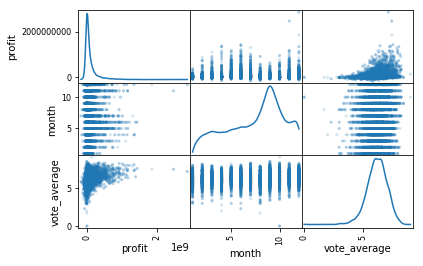

In [25]:
# Plot the data, using scatter_matrix, from Pandas. Assign it to a variable called 'fig'.
fig = pd.plotting.scatter_matrix(df[['profit','month','vote_average']], alpha=0.2, diagonal='kde')

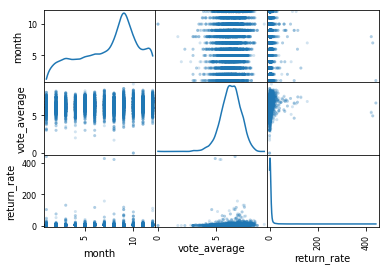

In [26]:
fig = pd.plotting.scatter_matrix(df[['month','vote_average','return_rate']], alpha=0.2, diagonal='kde')

We can see that most of the movies' return rates are close to each other and under 100, but there are some movies with extremely high return rate.

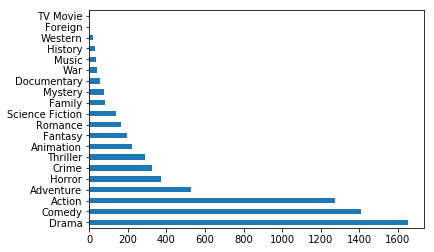

In [27]:
# Plot a bar chart showing the number of movies in each genre. 
df.main_genre.value_counts().plot.barh()
f1 = plt.gcf()

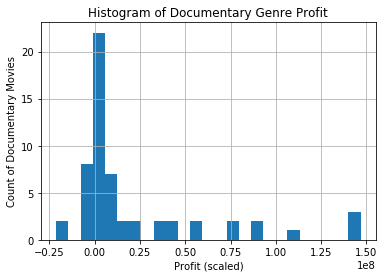

In [28]:
df[df["main_genre"] == 'Documentary'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Documentary Movies')
plt.title('Histogram of Documentary Genre Profit')
f_Documentary = plt.gcf()

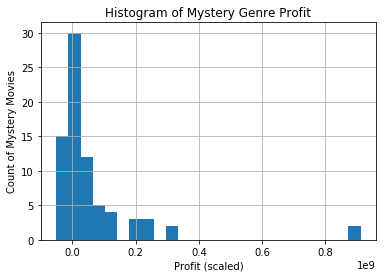

In [29]:
df[df["main_genre"] == 'Mystery'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Mystery Movies')
plt.title('Histogram of Mystery Genre Profit')
f_Mystery = plt.gcf()

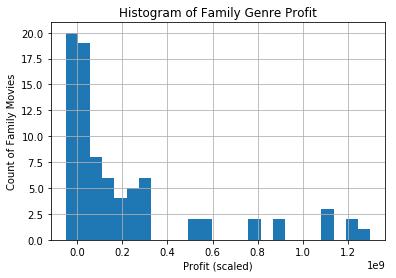

In [30]:
df[df["main_genre"] == 'Family'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Family Movies')
plt.title('Histogram of Family Genre Profit')
f_Family = plt.gcf()

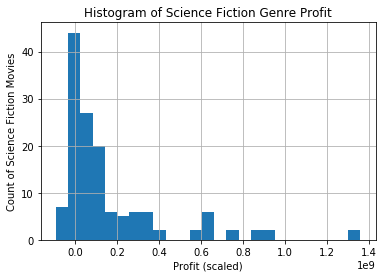

In [31]:
df[df["main_genre"] == 'Science Fiction'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Science Fiction Movies')
plt.title('Histogram of Science Fiction Genre Profit')
f_Science_Fiction = plt.gcf()

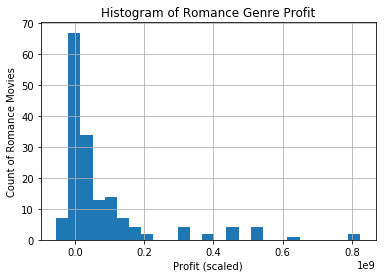

In [32]:
df[df["main_genre"] == 'Romance'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Romance Movies')
plt.title('Histogram of Romance Genre Profit')
f_Romance = plt.gcf()

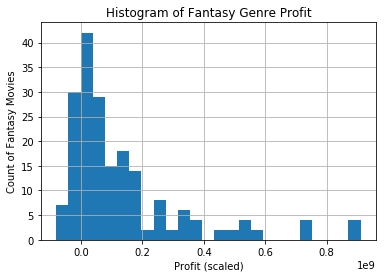

In [33]:
df[df["main_genre"] == 'Fantasy'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Fantasy Movies')
plt.title('Histogram of Fantasy Genre Profit')
f_Fantasy = plt.gcf()

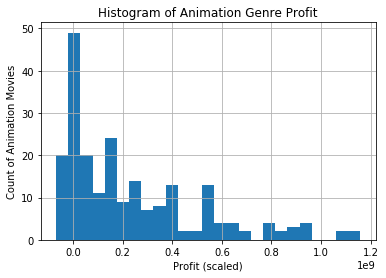

In [34]:
df[df["main_genre"] == 'Animation'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Animation Movies')
plt.title('Histogram of Animation Genre Profit')
f_Animation = plt.gcf()

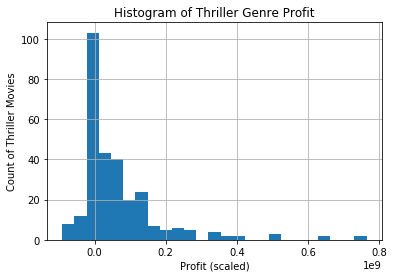

In [35]:
df[df["main_genre"] == 'Thriller'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Thriller Movies')
plt.title('Histogram of Thriller Genre Profit')
f_Animation = plt.gcf()

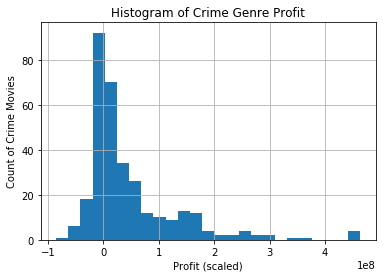

In [36]:
df[df["main_genre"] == 'Crime'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Crime Movies')
plt.title('Histogram of Crime Genre Profit')
f_Crime = plt.gcf()

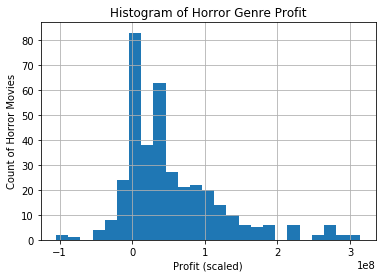

In [37]:
df[df["main_genre"] == 'Horror'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Horror Movies')
plt.title('Histogram of Horror Genre Profit')
f_Horror = plt.gcf()

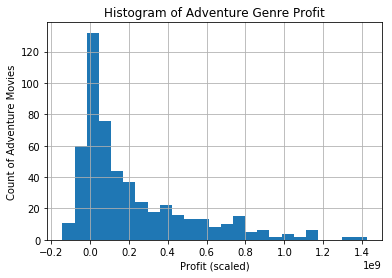

In [38]:
df[df["main_genre"] == 'Adventure'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Adventure Movies')
plt.title('Histogram of Adventure Genre Profit')
f_Adventure = plt.gcf()

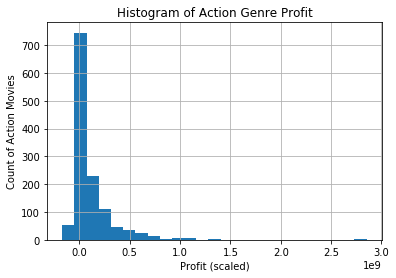

In [39]:
df[df["main_genre"] == 'Action'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Action Movies')
plt.title('Histogram of Action Genre Profit')
f_Action = plt.gcf()

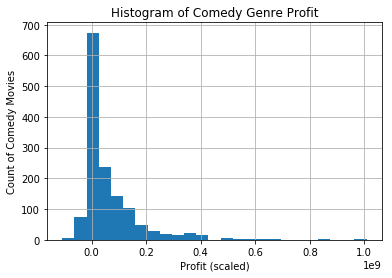

In [40]:
df[df["main_genre"] == 'Comedy'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Comedy Movies')
plt.title('Histogram of Comedy Genre Profit')
f_Comedy = plt.gcf()

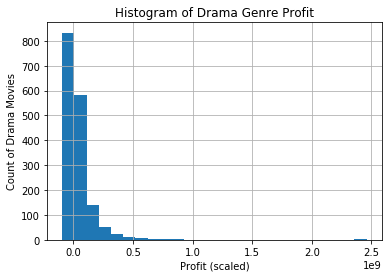

In [41]:
df[df["main_genre"] == 'Drama'].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of Drama Movies')
plt.title('Histogram of Drama Genre Profit')
f_Drama = plt.gcf()

Continuing to see profit trends depending on different variables, we will see profit trends concerning months.

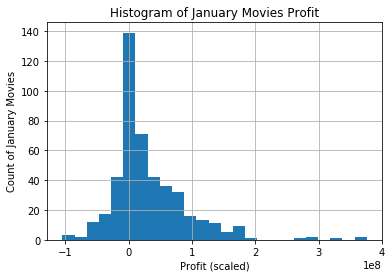

In [42]:
df[df["month"] == 1].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of January Movies')
plt.title('Histogram of January Movies Profit')
f_January = plt.gcf()

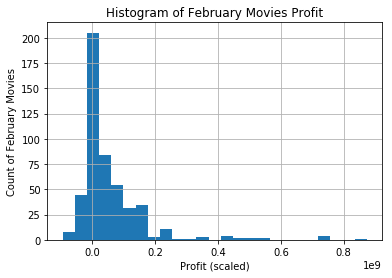

In [43]:
df[df["month"] == 2].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of February Movies')
plt.title('Histogram of February Movies Profit')
f_February = plt.gcf()

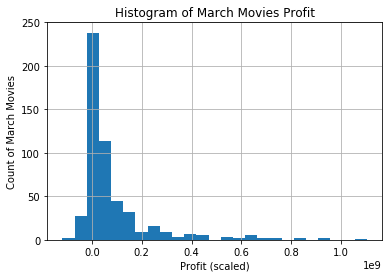

In [44]:
df[df["month"] == 3].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of March Movies')
plt.title('Histogram of March Movies Profit')
f_March = plt.gcf()

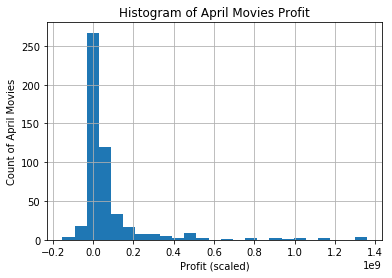

In [45]:
df[df["month"] == 4].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of April Movies')
plt.title('Histogram of April Movies Profit')
f_April = plt.gcf()

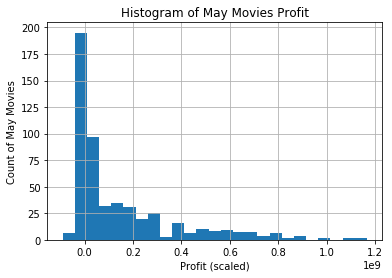

In [46]:
df[df["month"] == 5].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of May Movies')
plt.title('Histogram of May Movies Profit')
f_May = plt.gcf()

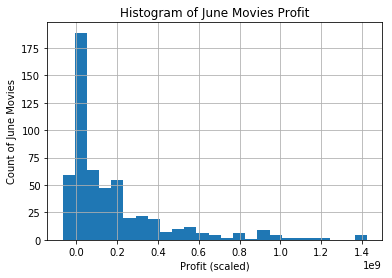

In [47]:
df[df["month"] == 6].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of June Movies')
plt.title('Histogram of June Movies Profit')
f_June = plt.gcf()

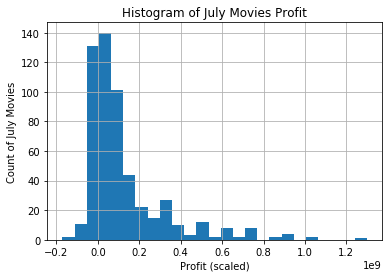

In [48]:
df[df["month"] == 7].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of July Movies')
plt.title('Histogram of July Movies Profit')
f_July = plt.gcf()

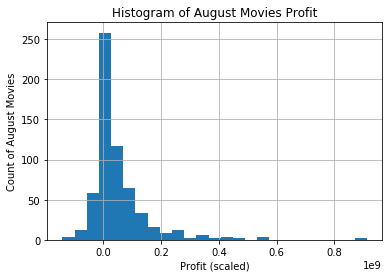

In [49]:
df[df["month"] == 8].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of August Movies')
plt.title('Histogram of August Movies Profit')
f_August = plt.gcf()

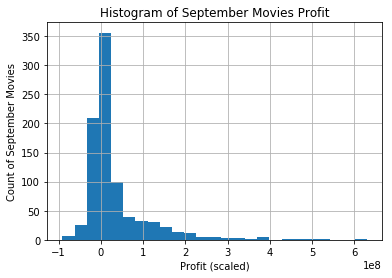

In [50]:
df[df["month"] == 9].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of September Movies')
plt.title('Histogram of September Movies Profit')
f_September = plt.gcf()

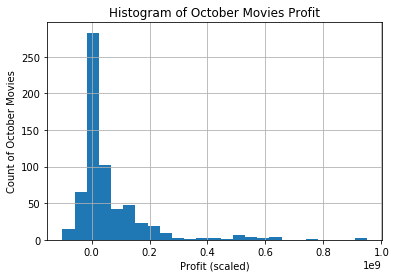

In [51]:
df[df["month"] == 10].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of October Movies')
plt.title('Histogram of October Movies Profit')
f_October = plt.gcf()

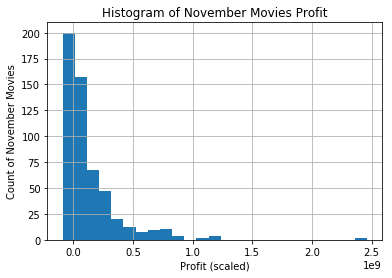

In [52]:
df[df["month"] == 11].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of November Movies')
plt.title('Histogram of November Movies Profit')
f_November = plt.gcf()

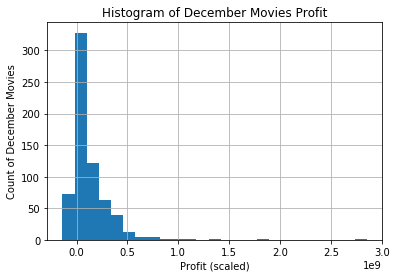

In [53]:
df[df["month"] == 12].hist(column='profit', bins=25)
plt.xlabel('Profit (scaled)')
plt.ylabel('Count of December Movies')
plt.title('Histogram of December Movies Profit')
f_December = plt.gcf()

# Data Analysis and Results

In [108]:
# Average vote count
def avg_vote(df):
    values = df.value_counts().keys().tolist()
    return sum(values)/len(values)

In [54]:
# Contain each month's profit values in a separate list 
pro_jan = df[df['month'] == 1]['profit'].values
pro_feb = df[df['month'] == 2]['profit'].values
pro_mar = df[df['month'] == 3]['profit'].values
pro_apr = df[df['month'] == 4]['profit'].values
pro_may = df[df['month'] == 5]['profit'].values
pro_jun = df[df['month'] == 6]['profit'].values
pro_jul = df[df['month'] == 7]['profit'].values
pro_aug = df[df['month'] == 8]['profit'].values
pro_sep = df[df['month'] == 9]['profit'].values
pro_oct = df[df['month'] == 10]['profit'].values
pro_nov = df[df['month'] == 11]['profit'].values
pro_dec = df[df['month'] == 12]['profit'].values

In [55]:
# Use the 'normaltest' function to test for normality of the distribution
st_jan, p_jan = stats.normaltest(pro_jan)
st_feb, p_feb = stats.normaltest(pro_feb)
st_mar, p_mar = stats.normaltest(pro_mar)
st_apr, p_apr = stats.normaltest(pro_apr)
st_may, p_may = stats.normaltest(pro_may)
st_jun, p_jun = stats.normaltest(pro_jun)
st_jul, p_jul = stats.normaltest(pro_jul)
st_aug, p_aug = stats.normaltest(pro_aug)
st_sep, p_sep = stats.normaltest(pro_sep)
st_oct, p_oct = stats.normaltest(pro_oct)
st_nov, p_nov = stats.normaltest(pro_nov)
st_dec, p_dec = stats.normaltest(pro_dec)

if p_jun < 0.05:
    is_n_jan = False
else:
    is_n_jan = True
print(is_n_jan)

xs = np.arange(pro_jan.min(), pro_jan.max(), 0.1)
fit = stats.norm.pdf(xs, np.mean(pro_jan), np.std(pro_jan))
plt.plot(xs, fit, label='Normal Dist.', lw=4)
plt.hist(pro_jan, normed=True, label='Actual Data');
plt.title('January - profit')
plt.legend();

In [56]:
avg_pro_jan = pro_jan.mean()
avg_pro_feb = pro_feb.mean()
avg_pro_mar = pro_mar.mean()
avg_pro_apr = pro_apr.mean()
avg_pro_may = pro_may.mean()
avg_pro_jun = pro_jun.mean()
avg_pro_jul = pro_jul.mean()
avg_pro_aug = pro_aug.mean()
avg_pro_sep = pro_sep.mean()
avg_pro_oct = pro_oct.mean()
avg_pro_nov = pro_nov.mean()
avg_pro_dec = pro_dec.mean()

In [57]:
print('Average profit of movie in January is \t {:2.2f} dollar'.format(avg_pro_jan))
print('Average profit of movie in Febuaray is \t {:2.2f} dollar'.format(avg_pro_feb))
print('Average profit of movie in March is \t {:2.2f} dollar'.format(avg_pro_mar))
print('Average profit of movie in April is \t {:2.2f} dollar'.format(avg_pro_apr))
print('Average profit of movie in May is \t {:2.2f} dollar'.format(avg_pro_may))
print('Average profit of movie in June is \t {:2.2f} dollar'.format(avg_pro_jun))
print('Average profit of movie in July is \t {:2.2f} dollar'.format(avg_pro_jul))
print('Average profit of movie in August is \t {:2.2f} dollar'.format(avg_pro_aug))
print('Average profit of movie in September is  {:2.2f} dollar'.format(avg_pro_sep))
print('Average profit of movie in October is \t {:2.2f} dollar'.format(avg_pro_oct))
print('Average profit of movie in November is \t {:2.2f} dollar'.format(avg_pro_nov))
print('Average profit of movie in December is \t {:2.2f} dollar'.format(avg_pro_dec))

Average profit of movie in January is 	 31655624.65 dollar
Average profit of movie in Febuaray is 	 56662274.75 dollar
Average profit of movie in March is 	 80285946.33 dollar
Average profit of movie in April is 	 77980611.79 dollar
Average profit of movie in May is 	 149088083.79 dollar
Average profit of movie in June is 	 179833688.15 dollar
Average profit of movie in July is 	 124940887.27 dollar
Average profit of movie in August is 	 51406928.76 dollar
Average profit of movie in September is  34533475.23 dollar
Average profit of movie in October is 	 58234800.28 dollar
Average profit of movie in November is 	 138022721.86 dollar
Average profit of movie in December is 	 127906975.90 dollar


In [58]:
list = [avg_pro_jan,avg_pro_feb,avg_pro_mar,avg_pro_apr,avg_pro_may,avg_pro_jun,avg_pro_jul,avg_pro_aug,avg_pro_sep,
        avg_pro_oct,avg_pro_nov,avg_pro_dec]
list.sort(key=int)
list

[31655624.647724286,
 34533475.231767394,
 51406928.759983465,
 56662274.747449398,
 58234800.276167184,
 77980611.791245043,
 80285946.325152084,
 124940887.27175502,
 127906975.89620215,
 138022721.86149445,
 149088083.78514177,
 179833688.1545803]

Looking at the sorted list above, we can see that June, May, November, December, and July are making more profit in movies compared to the rest of the month. The months we listed are making about a hundred million dollars, whereas the rest of the month are making tens of millions dollars.

Now, let's find the average profit of movies in different genres

In [60]:
pro_Drama = df[df['main_genre'] == "Drama"]['profit'].values
pro_Comedy = df[df['main_genre'] == "Comedy"]['profit'].values
pro_Action = df[df['main_genre'] == "Action"]['profit'].values
pro_Adventure = df[df['main_genre'] == "Adventure"]['profit'].values
pro_Crime = df[df['main_genre'] == "Crime"]['profit'].values
pro_Horror = df[df['main_genre'] == "Horror"]['profit'].values
pro_Animation = df[df['main_genre'] == "Animation"]['profit'].values
pro_Fantasy = df[df['main_genre'] == "Fantasy"]['profit'].values
pro_Thriller = df[df['main_genre'] == "Thriller"]['profit'].values
pro_Romance = df[df['main_genre'] == "Romance"]['profit'].values
pro_Science_Fiction = df[df['main_genre'] == "Science Fiction"]['profit'].values
pro_Family = df[df['main_genre'] == "Family"]['profit'].values
pro_Mystery = df[df['main_genre'] == "Mystery"]['profit'].values
pro_Documentary = df[df['main_genre'] == "Documentary"]['profit'].values

In [61]:
avg_pro_Drama = pro_Drama.mean()
avg_pro_Comedy = pro_Comedy.mean()
avg_pro_Action = pro_Action.mean()
avg_pro_Adventure = pro_Adventure.mean()
avg_pro_Crime = pro_Crime.mean()
avg_pro_Animation = pro_Animation.mean()
avg_pro_Horror = pro_Horror.mean()
avg_pro_Thriller = pro_Thriller.mean()
avg_pro_Fantasy = pro_Fantasy.mean()
avg_pro_Romance = pro_Romance.mean()
avg_pro_Science_Fiction = pro_Science_Fiction.mean()
avg_pro_Family = pro_Family.mean()
avg_pro_Mystery = pro_Mystery.mean()
avg_pro_Documentary = pro_Documentary.mean()

In [62]:
print('Average profit of Drama movie is \t\t {:2.2f} dollar'.format(avg_pro_Drama))
print('Average profit of Comedy movie is \t\t {:2.2f} dollar'.format(avg_pro_Comedy))
print('Average profit of Action movie is \t\t {:2.2f} dollar'.format(avg_pro_Action))
print('Average profit of Adventure movie is \t\t {:2.2f} dollar'.format(avg_pro_Adventure))
print('Average profit of Horror movie is \t\t {:2.2f} dollar'.format(avg_pro_Horror))
print('Average profit of Crime movie is \t\t {:2.2f} dollar'.format(avg_pro_Crime))
print('Average profit of Animation movie is \t\t {:2.2f} dollar'.format(avg_pro_Animation))
print('Average profit of Thriller movie is \t\t {:2.2f} dollar'.format(avg_pro_Thriller))
print('Average profit of Fantasy movie is \t\t {:2.2f} dollar'.format(avg_pro_Fantasy))
print('Average profit of Romance movie is \t\t {:2.2f} dollar'.format(avg_pro_Romance))
print('Average profit of Science Fiction movie is \t {:2.2f} dollar'.format(avg_pro_Science_Fiction))
print('Average profit of Family movie is \t\t {:2.2f} dollar'.format(avg_pro_Family))
print('Average profit of Mystery movie is \t\t {:2.2f} dollar'.format(avg_pro_Mystery))
print('Average profit of Documentary movie is \t\t {:2.2f} dollar'.format(avg_pro_Documentary))

Average profit of Drama movie is 		 47961178.04 dollar
Average profit of Comedy movie is 		 64520654.63 dollar
Average profit of Action movie is 		 111922095.10 dollar
Average profit of Adventure movie is 		 215574544.64 dollar
Average profit of Horror movie is 		 53424829.72 dollar
Average profit of Crime movie is 		 47262326.52 dollar
Average profit of Animation movie is 		 235298510.68 dollar
Average profit of Thriller movie is 		 67542312.04 dollar
Average profit of Fantasy movie is 		 132690473.13 dollar
Average profit of Romance movie is 		 81438396.85 dollar
Average profit of Science Fiction movie is 	 164542148.53 dollar
Average profit of Family movie is 		 221779166.51 dollar
Average profit of Mystery movie is 		 64800321.54 dollar
Average profit of Documentary movie is 		 22088386.38 dollar


Find the movie averages of each month.

In [115]:
vote_jan = df[df["month"] == 1]["vote_average"].values
vote_feb = df[df["month"] == 2]["vote_average"].values
vote_mar = df[df["month"] == 3]["vote_average"].values
vote_apr = df[df["month"] == 4]["vote_average"].values
vote_may = df[df["month"] == 5]["vote_average"].values
vote_jun = df[df["month"] == 6]["vote_average"].values
vote_jul = df[df["month"] == 7]["vote_average"].values
vote_aug = df[df["month"] == 8]["vote_average"].values
vote_sep = df[df["month"] == 9]["vote_average"].values
vote_oct = df[df["month"] == 10]["vote_average"].values
vote_nov = df[df["month"] == 11]["vote_average"].values
vote_dec = df[df["month"] == 12]["vote_average"].values


In [117]:
avg_vote_jan = vote_jan.mean()
avg_vote_feb = vote_feb.mean()
avg_vote_mar = vote_mar.mean()
avg_vote_apr = vote_apr.mean()
avg_vote_may = vote_may.mean()
avg_vote_jun = vote_jun.mean()
avg_vote_jul = vote_jul.mean()
avg_vote_aug = vote_aug.mean()
avg_vote_sep = vote_sep.mean()
avg_vote_oct = vote_oct.mean()
avg_vote_nov = vote_nov.mean()
avg_vote_dec = vote_dec.mean()

In [118]:
print("The average vote in January is: \t", avg_vote_jan)
print("The average vote in February is: \t", avg_vote_feb)
print("The average vote in March is: \t\t", avg_vote_mar)
print("The average vote in April is: \t\t", avg_vote_apr)
print("The average vote in May is: \t\t", avg_vote_may)
print("The average vote in June is: \t\t", avg_vote_jun)
print("The average vote in July is: \t\t", avg_vote_jul)
print("The average vote in August is: \t\t", avg_vote_aug)
print("The average vote in September is: \t", avg_vote_sep)
print("The average vote in October is: \t", avg_vote_oct)
print("The average vote in November is: \t", avg_vote_nov)
print("The average vote in December is: \t", avg_vote_dec)

The average vote in January is: 	 6.00656455142
The average vote in February is: 	 6.11255060729
The average vote in March is: 		 6.1427756654
The average vote in April is: 		 6.11996047431
The average vote in May is: 		 6.36465028355
The average vote in June is: 		 6.17116788321
The average vote in July is: 		 6.22669104205
The average vote in August is: 		 6.03520661157
The average vote in September is: 	 6.35917901938
The average vote in October is: 	 6.288170347
The average vote in November is: 	 6.35811808118
The average vote in December is: 	 6.45099540582


### Linear Models
In the next following cells, we will make some linear models, using Ordinary Least Squares (OLS). 

In [120]:
# Creates a linear model to predict profit from month (using df as data)
outcome_1, predictors_1 = patsy.dmatrices('profit ~ month', df)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()

In [121]:
# Print out the summary results of the model fitting
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     16.82
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           4.15e-05
Time:                        04:58:52   Log-Likelihood:            -1.4160e+05
No. Observations:                6918   AIC:                         2.832e+05
Df Residuals:                    6916   BIC:                         2.832e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.172e+07   5.12e+06     14.010      0.0

In [125]:
# Creates a linear model to predict profit from both month and genre (using df as data)
outcome_2, predictors_2 = patsy.dmatrices('profit ~ month + main_genre', df)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()

In [126]:
# Print out the results 
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     34.96
Date:                Thu, 22 Mar 2018   Prob (F-statistic):          2.22e-128
Time:                        05:03:27   Log-Likelihood:            -1.4128e+05
No. Observations:                6918   AIC:                         2.826e+05
Df Residuals:                    6897   BIC:                         2.827e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [127]:
# Creates a linear model to predict profit from both month, main production, and genre (using df as data)
outcome_3, predictors_3 = patsy.dmatrices('profit ~ month + main_genre + main_production_company', df)
mod_3 = sm.OLS(outcome_3, predictors_3)
res_3 = mod_3.fit()

In [128]:
# Print out the results 
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     2.175
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           8.72e-77
Time:                        05:09:42   Log-Likelihood:            -1.4036e+05
No. Observations:                6918   AIC:                         2.830e+05
Df Residuals:                    5760   BIC:                         2.910e+05
Df Model:                        1157                                         
Covariance Type:            nonrobust                                         
                                                                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [129]:
# Creates a linear model to predict profit from vote_average (using df as data)
outcome_4, predictors_4 = patsy.dmatrices('profit ~ vote_average', df)
mod_4 = sm.OLS(outcome_4, predictors_4)
res_4 = mod_4.fit()

In [130]:
# Print out the results 
print(res_4.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     485.6
Date:                Thu, 22 Mar 2018   Prob (F-statistic):          4.53e-104
Time:                        05:13:25   Log-Likelihood:            -1.4138e+05
No. Observations:                6918   AIC:                         2.828e+05
Df Residuals:                    6916   BIC:                         2.828e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -2.59e+08    1.6e+07    -16.175   

In [132]:
# Creates a linear model to predict profit from both vote_average and genre (using df as data)
outcome_5, predictors_5 = patsy.dmatrices('profit ~ vote_average + main_genre', df)
mod_5 = sm.OLS(outcome_5, predictors_5)
res_5 = mod_5.fit()

In [133]:
# Print out the results 
print(res_5.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     69.16
Date:                Thu, 22 Mar 2018   Prob (F-statistic):          3.61e-255
Time:                        05:14:58   Log-Likelihood:            -1.4098e+05
No. Observations:                6918   AIC:                         2.820e+05
Df Residuals:                    6897   BIC:                         2.821e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [135]:
# Creates a linear model to predict profit from both month and vote_average (using df as data)
outcome_6, predictors_6 = patsy.dmatrices('profit ~ vote_average + month', df)
mod_6 = sm.OLS(outcome_6, predictors_6)
res_6 = mod_6.fit()

In [136]:
# Print out the results 
print(res_6.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     244.2
Date:                Thu, 22 Mar 2018   Prob (F-statistic):          3.19e-103
Time:                        05:16:53   Log-Likelihood:            -1.4137e+05
No. Observations:                6918   AIC:                         2.828e+05
Df Residuals:                    6915   BIC:                         2.828e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -2.633e+08   1.62e+07    -16.233   

In [137]:
# Creates a linear model to predict profit from adjusted_budget (using df as data)
outcome_7, predictors_7 = patsy.dmatrices('profit ~ adjusted_budget', df)
mod_7 = sm.OLS(outcome_7, predictors_7)
res_7 = mod_7.fit()

In [138]:
# Print out the results 
print(res_7.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     2903.
Date:                Thu, 22 Mar 2018   Prob (F-statistic):               0.00
Time:                        05:18:58   Log-Likelihood:            -1.4040e+05
No. Observations:                6918   AIC:                         2.808e+05
Df Residuals:                    6916   BIC:                         2.808e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -8.284e+06   2.64e+06     

In [139]:
# Creates a linear model to predict profit from both adjusted_budget and vote_average (using df as data)
outcome_8, predictors_8 = patsy.dmatrices('profit ~ adjusted_budget + vote_average', df)
mod_8 = sm.OLS(outcome_8, predictors_8)
res_8 = mod_8.fit()

In [140]:
# Print out the results 
print(res_8.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     1899.
Date:                Thu, 22 Mar 2018   Prob (F-statistic):               0.00
Time:                        05:20:51   Log-Likelihood:            -1.4010e+05
No. Observations:                6918   AIC:                         2.802e+05
Df Residuals:                    6915   BIC:                         2.802e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -3.384e+08   1.34e+07    -

In [141]:
# Creates a linear model to predict profit from both month, adjusted_budget, and vote_average (using df as data)
outcome_9, predictors_9 = patsy.dmatrices('profit ~ adjusted_budget + vote_average + month', df)
mod_9 = sm.OLS(outcome_9, predictors_9)
res_9 = mod_9.fit()

In [142]:
# Print out the results 
print(res_9.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     1266.
Date:                Thu, 22 Mar 2018   Prob (F-statistic):               0.00
Time:                        05:23:04   Log-Likelihood:            -1.4010e+05
No. Observations:                6918   AIC:                         2.802e+05
Df Residuals:                    6914   BIC:                         2.802e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -3.369e+08   1.35e+07    -

# Privacy/Ethics Considerations
We do have permission to use this data, for this purpose. These are open, public datasets released on Kaggle. There are no privacy concerns regarding our datasets that we need to deal with and there are no terms of use that we need to comply with. However, there are biases in our dataset. These lists contain more American movies, so the genres are more geared toward Hollywood. Also, due to inflation, the value of money varied by year. To address this, we used an inflation rate package to find the adjusted value for ‘budget’ and ‘revenue’ (to the year 2016). We also trimmed the list to movies made after 1989. There did not seem to be any other issues related to our topic area, data, and/or analyses that are problematic in terms of data privacy and equitable impact.

# Conclusions and Discussions